# Handling Grid-Data from the German Census – A Beginners' Tutorial  
We're using Python and Pandas to preprocess the csv-files offered from the official website. You could use R or any other suitable software as well but files are too large for spreadsheet programmes like Excel oder LibreOffice Calc. An example using the open source software [QGIS](https://qgis.org) is provided as well.

You may want to familiarize yourself with the data beforehand. There is an interactive atlas with some choropleth maps for the 1km-grid at https://atlas.zensus2011.de/  

Grid-based data can be downloaded from 
https://www.zensus2011.de/DE/Home/Aktuelles/DemografischeGrunddaten.html?nn=559100#Gitter  
each ZIP-file contains the csv and an Excel spreadsheet with documentation (in German)

In [1]:
# the following code has been tested with Pandas version 1.5.2
import pandas as pd

## Download and prepare the data

### Example: Dwellings from the 2011 German Census, 100m-Grid

Data on the 100m-grid for the whole of Germany can result in quite large filesizes.  
You may therefore keep the files as zipped archives.   

Download the file `csv_Wohnungen_100m_Gitter.zip` from  
https://www.zensus2011.de/SharedDocs/Downloads/DE/Pressemitteilung/DemografischeGrunddaten/csv_Wohnungen_100m_Gitter.zip?__blob=publicationFile&v=2  
this is a 256 MB download, make sure it has completed and keep it in your current directory 

The above ZIP archive contains two files  
`Datensatzbeschreibung_Gitter100m_GebWhg.xlsx` : Documentation of the csv in German (100 kB)  
`Wohnungen100m.csv` : the data (**4.6 GB**)  

csv-files from official german sources may come in encodings other than `utf-8` in this case it is `windows 1252` which pandas can handle as long as we tell it to do so

In [2]:
# https://stackoverflow.com/questions/44575251/reading-multiple-files-contained-in-a-zip-file-with-pandas
  
from zipfile import ZipFile

zip_file = ZipFile('csv_Wohnungen_100m_Gitter.zip')

csv_df_dict_from_zip = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename), encoding="cp1252")
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [3]:
# the above results in a dictionary of dataframes read from csv-files, in this case just the one
csv_df_dict_from_zip['Wohnungen100m.csv'].head(7)

,Gitter_ID_100m,Gitter_ID_100m_neu,Merkmal,Auspraegung_Code,Auspraegung_Text,Anzahl,Anzahl_q
0,100mN26865E43357,CRS3035RES100mN2686500E4335700,INSGESAMT,0,Einheiten insgesamt,3,0
1,100mN26865E43357,CRS3035RES100mN2686500E4335700,HEIZTYP,4,Zentralheizung,3,0
2,100mN26865E43357,CRS3035RES100mN2686500E4335700,WOHNEIGENTUM,99,Trifft nicht zu (da keine Eigentumswohnung),3,0
3,100mN26865E43357,CRS3035RES100mN2686500E4335700,ZAHLWOHNGN_HHG,1,1 Wohnung,3,0
4,100mN26891E43370,CRS3035RES100mN2689100E4337000,INSGESAMT,0,Einheiten insgesamt,3,0
5,100mN26891E43370,CRS3035RES100mN2689100E4337000,BAUJAHR_MZ,3,1949 - 1978,3,0
6,100mN26891E43370,CRS3035RES100mN2689100E4337000,GEBTYPBAUWEISE,4,Anderer Gebäudetyp,3,0


## Filtering the data

### Respect the quality flag

Due to disclosure control measures data might be more or less reliable.  
The quality variable `Anzahl_q` ("Geheimhaltungskennzeichnung") denotes 

`q=0` means no or minimal difference before/after disclosure control  
`q=1` means strong difference before/after disclosure control  
`q=2` means difference before/after disclosure control not acceptable  

For this example we will opt for the most reliable data only

In [4]:
dwellings100m = csv_df_dict_from_zip['Wohnungen100m.csv'][csv_df_dict_from_zip['Wohnungen100m.csv']["Anzahl_q"]==0]

### Get dominating year of construction of dwellings for grid cells in built-up areas

For this example we are only considering the variable `year of construction` ("BAUJAHR_MZ").  
We therefore pivot the dataframe to have just the dwelling count per year of construction epoch.

In [5]:
dwell100m_YrConstruct = dwellings100m[dwellings100m["Merkmal"]=="BAUJAHR_MZ"] \
                        .pivot(index=["Gitter_ID_100m"], columns=["Auspraegung_Text"], values=["Anzahl"])                         

In [6]:
dwell100m_YrConstruct.head(3)

Anzahl                                                  \
Auspraegung_Text 1919 - 1948 1949 - 1978 1979 - 1986 1987 - 1990 1991 - 1995   
Gitter_ID_100m                                                                 
100mN26891E43370         NaN         3.0         NaN         NaN         NaN   
100mN26912E43412         NaN         NaN         NaN         NaN         NaN   
100mN26917E43411         NaN         3.0         NaN         3.0         NaN   

                                                                               
Auspraegung_Text 1996 - 2000 2001 - 2004 2005 - 2008 2009 und später Vor 1919  
Gitter_ID_100m                                                                 
100mN26891E43370         NaN         NaN         NaN             NaN      NaN  
100mN26912E43412         NaN         NaN         NaN             NaN      3.0  
100mN26917E43411         NaN         NaN         NaN             NaN      NaN

In [7]:
dwell100m_YrConstruct.columns = dwell100m_YrConstruct.columns.droplevel(0)

In [8]:
dwell100m_YrConstruct.reset_index(inplace=True)

In [9]:
dwell100m_YrConstruct.head(3)

Auspraegung_Text,Gitter_ID_100m,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000,2001 - 2004,2005 - 2008,2009 und später,Vor 1919
0,100mN26891E43370,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100mN26912E43412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,100mN26917E43411,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# find dominating building age
# NA/null values are excluded by default => built-up areas only
dwell100m_YrConstruct["dominBuildAge"] = dwell100m_YrConstruct.idxmax(axis=1, numeric_only=True)

`numeric_only` requires Pandas 1.5

In [11]:
dwell100m_YrConstruct.head(3)

Auspraegung_Text,Gitter_ID_100m,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000,2001 - 2004,2005 - 2008,2009 und später,Vor 1919,dominBuildAge
0,100mN26891E43370,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949 - 1978
1,100mN26912E43412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Vor 1919
2,100mN26917E43411,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1949 - 1978


### Extract x,y-coordinates from grid ID (INSPIRE Standard)
Grid cells are referenced by the lower left corner, e.g. `100mN26891E43370`    
To get the center coordinates, half the grid width has to be added  
grid id uses first 5 digits of North/East coordinates => *100 = metres

In [12]:
dwell100m_YrConstruct[["ystr","xstr"]] = dwell100m_YrConstruct["Gitter_ID_100m"].str.split("E", expand=True)

In [13]:
dwell100m_YrConstruct["ynum"] = dwell100m_YrConstruct["ystr"].str.slice(5,11)

In [14]:
dwell100m_YrConstruct["center_x"] = dwell100m_YrConstruct["xstr"]+"50"
dwell100m_YrConstruct["center_y"] = dwell100m_YrConstruct["ynum"]+"50"

In [15]:
dwell100m_YrConstruct.head(3)

Auspraegung_Text,Gitter_ID_100m,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000,2001 - 2004,2005 - 2008,2009 und später,Vor 1919,dominBuildAge,ystr,xstr,ynum,center_x,center_y
0,100mN26891E43370,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949 - 1978,100mN26891,43370,26891,4337050,2689150
1,100mN26912E43412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Vor 1919,100mN26912,43412,26912,4341250,2691250
2,100mN26917E43411,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1949 - 1978,100mN26917,43411,26917,4341150,2691750


### Output filtered data to csv (64 MB)

In [16]:
dwell100m_YrConstruct[["center_x", "center_y", "dominBuildAge"]].to_csv("dwell100m_dominBuildAge.csv", index=None)

# Building a Choropleth Map from Gridded Data using QGis
The following screenshots show QGis version 3.28 on MacOS but the process will work on earlier versions and operating systems just as well.  

### Prepare a Background Map

To make sense of gridded data we will use mapping tiles from the German Mapping Authority (BKG), which we load as WMS from https://basemap.de (OpenData)

Since we want to overlay the census data in different colors to denote certain statistical values, the background map is best used in gray shading only.

<img src="screenshots/01_wms_manager.jpg" width="600">

1) If you haven't already, add the WMS basemap service https://basemap.de/dienste/wms_capabilities_web_raster.xml 
2) Connect to the basemap service and chosse the desired tileset 

<img src="screenshots/02_basemap.jpg" width="800">

Since the gridded census data conforms to the INSPIRE standard, its projection is `EPSG:3035` (LAEA). So make sure that the background map is projected that way.

### Load csv Delimited Text as Point Coordinates

<img src="screenshots/03_csv_projected_points.jpg" width="800">

1) In the Data Source Manager select the file `dwell100m_dominBuildAge.csv` in the *Delimited Text* section  
Make sure the Geometry Definition is set to *Point Coordinates* and that the `x/y-fields` match the respective data columns
2) Set the projection to `EPSG:3035`

### Check if data is loaded correctly
By default for each coordinate pair or each line of the dataset a circle symbol is drawn on the map. Because we included only grid-cells that contain dwellings we can check against the underlying map if the built-up areas match. If they don't, make sure the projections of all layers are `EPSG:3035` and that x,y-values are set correctly.

<img src="screenshots/04_default_circle_symbols_match_builtup_area.jpg" width="800">

### Adjust the symbol settings to achieve a contiguous choropleth map

<img src="screenshots/05_symbol_settings.jpg" width="400">

1) Select a square as simple marker
2) Set the size of that marker to map units so that it will span 100x100m
3) The way we preprocessed the coordinates we need the anchor point of the symbol to be its center
4) The symbol should have a solid fill and no stroke

### Make a Thematic Layer – Adjusting Symbology 

![img06](screenshots/06_symbology.jpg)

1) We have prepared categorical data and thus choose `Categorized` in the *Symbology* panel
2) The value to be mapped in this example is `dominBuildAge` - press *Classify* after selecting the Value Variable to get an overview of the data
3) To start simple we only want to color-shade areas that have mainly been `built before 1919`
4) Make use of the powerful *Blending modes* provided by QGis that you might know from PhotoShop or the Gimp. In this case `Multiply` results in a glazing effect like a textmarker and underlying structures remain visible without reducing opacity

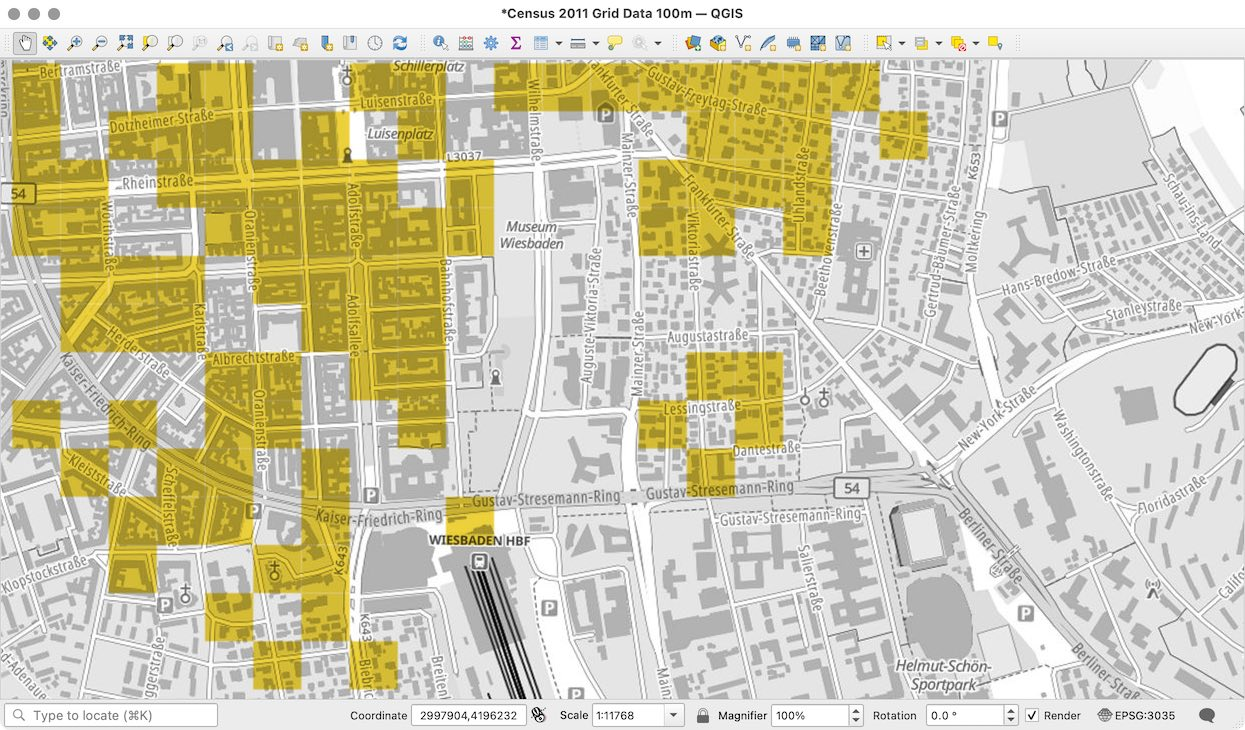

### The End